In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from scipy.stats import norm

In [2]:
# For reproducible results
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Advanced part - Generating new data

Some samples of the stars data:


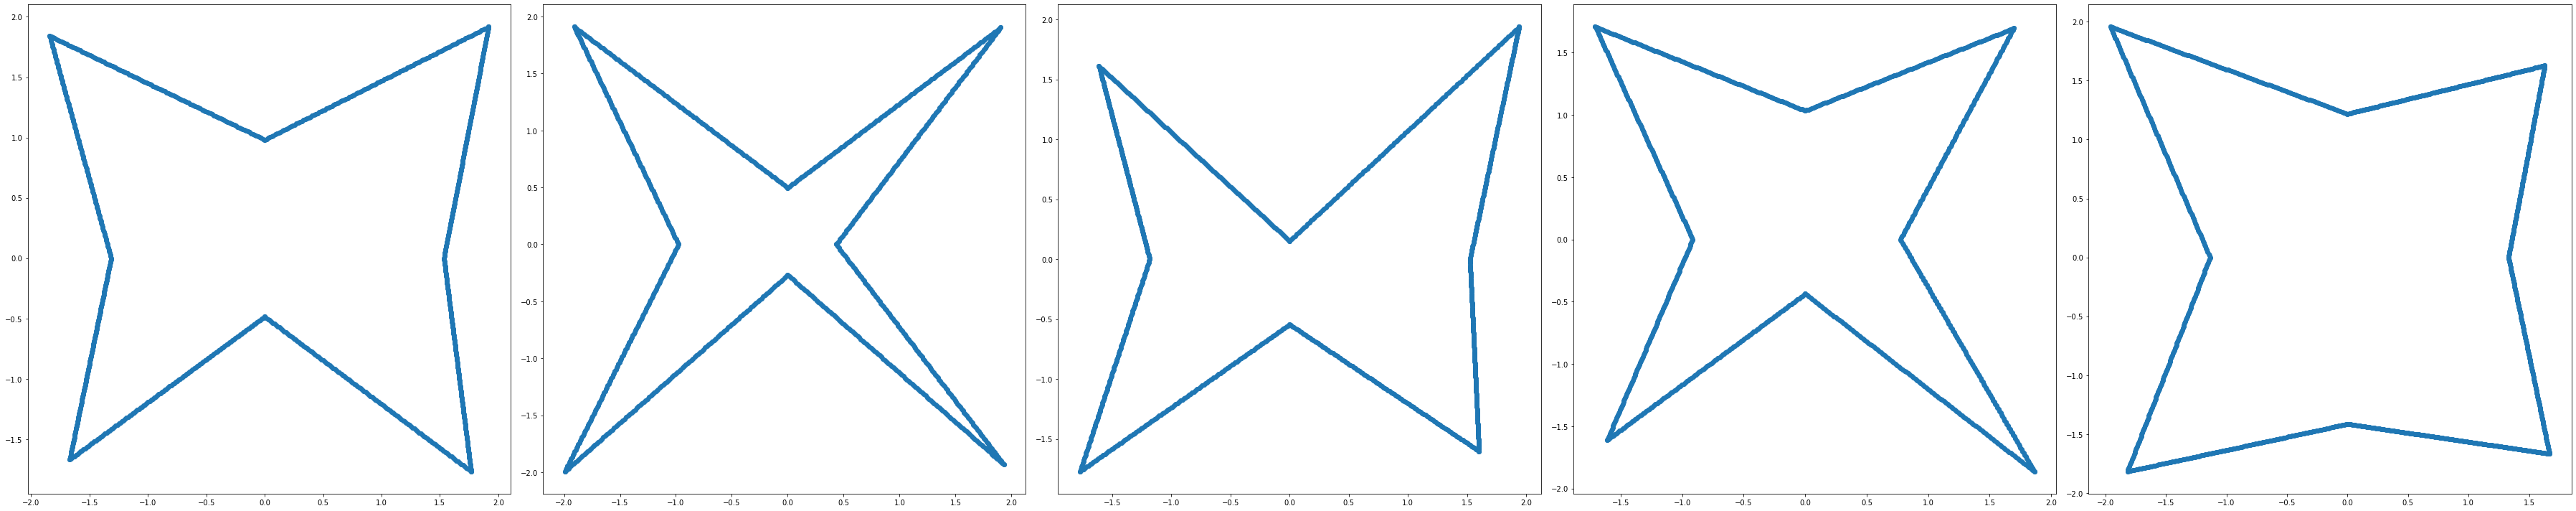

In [103]:
data_path = 'data'
stars_data = np.load(os.path.join(data_path, 'stars_data.npy'))

# Plot some sample stars
fig, axes = plt.subplots(1, 5, figsize=(50,10))
for i in range(5):
    star = random.choice(stars_data)
    axes[i].scatter(star[:, 0], star[:, 1])

print('Some samples of the stars data:')
plt.tight_layout()
plt.show()

In [33]:
# Learning constants
T = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
# Layer embedding inputs using high-frequency sinusoidals
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.tensor([10000.0], device=device)) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size, device=device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

In [35]:
# Linear variance schedule
# returns: tensor of shape [timesteps] containing all betas
def linear_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps, device=device)

# Compute all constants needed in forward and backward sampling
Bts = linear_beta_schedule(T, 0.0001, 0.02)
ats = 1.0 - Bts
ats_prods = torch.cumprod(ats, dim=0)
sqrt_ats_prods = torch.sqrt(ats_prods)
sqrt_ats_inv = torch.sqrt(1.0/ats)
sigmas = torch.sqrt(1.0 - ats_prods)
ats_prods_prev = F.pad(ats_prods[:-1], (1, 0), value=1.0) # shift ats_prods forward and let ats_prods_prev[0] = 1.0
Bt_tildes = (1.0-ats_prods_prev) / (1.0-ats_prods) * Bts
ut_tildes_et_factors = (1.0-ats)/(torch.sqrt(1.0-ats_prods)) 

In [36]:
# Uses closed formula to instantly compute xt from x0 and sampled noise e. Works with tensors of any length
# returns: xt
def forward_diffuse_closed_torch(x0, t, e):
    ut = torch.take(sqrt_ats_prods, t.long()-1) * x0
    sigmat = torch.take(sigmas, t.long()-1)
    return ut + sigmat*e

In [91]:
# Reverse samples n points from gaussian noise using provided model, returns corresponding star
def sample_star(model, T, n_points):
    
    xT = torch.randn((n_points, 2), device=device)  # Sample all xT from gaussian noise
    
    t = T
    xt = xT 
    
    # Reverse sample until we get xt=x0
    while (t > 0):
        t_tensor = torch.full((n_points, 1), t, device=device).float()
        t_indexes = t_tensor.long()-1
        
        # Get mean and var for the points in xt (calculated separately over x and y)
        mean = torch.mean(xt, dim=0)
        var = torch.var(xt, dim=0)  
        
        # Expand these from shape [2] -> [n_points, 2] 
        mean = mean.expand(xt.shape[0], 2)
        var = mean.expand(xt.shape[0], 2)
        
        # Predict noise and compute the reverse sampling
        et = model(xt, mean, var, t_tensor)
        ut_tilde = torch.take(sqrt_ats_inv, t_indexes) * (xt - torch.take(ut_tildes_et_factors, t_indexes) * et)
        Bt_tilde = torch.take(Bt_tildes, t_indexes)
        xt_prev = torch.normal(ut_tilde, torch.sqrt(Bt_tilde))
        t -= 1
        xt = xt_prev
        
    sampled_pts = xt.cpu().detach().numpy()  # our reverse sampled x0s as ndarrays
    return sampled_pts

In [92]:
# Our Neural Network model
class MLP_stars(torch.nn.Module):

    def __init__(self):
        super(MLP_stars, self).__init__()

        self.emb_size = 128
        self.embedding = SinusoidalEmbedding(self.emb_size)
        self.linear1 = torch.nn.Linear(self.emb_size*7, 1024)
        self.linear2 = torch.nn.Linear(1024, 512)
        self.linear3 = torch.nn.Linear(512, 128)
        self.linear4 = torch.nn.Linear(128, 2)
        self.activation = torch.nn.ReLU()

    def forward(self, xt, mean, var, t):
        x = torch.cat((xt, mean, var, t), dim=1)  # concatenate inputs along sample dimension
        x = self.embedding(x)             # embed input before processing
        x = torch.flatten(x, start_dim=1) # [batch_size, 7, emb_size] -> [batch_size, 7*emb_size]
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)     # no activation at output, since the noise e is continuous and possibly non-negaive
        return x  

In [93]:
def fit_stars_model(model, dataloader, optimizer, loss_fn, epochs):

    model.to(device)

    # Training loop
    for epoch in range(epochs):
    
        running_loss = 0.0
        n_batches = len(dataloader)
        for step, batch in enumerate(dataloader):
        
            # Transfers batch from cpu to device (needed when using gpu)
            batch = batch.float().to(device)   # also convert to float32 since this is torch default
            
            # Reset gradients
            optimizer.zero_grad()
            
            # List of noise tensors from all stars in batch
            e_list = []
            e_pred_list = []
            
            for star in batch:
                        
                # Sample common timestep and noise for points in star, apply forward diffusion
                t = torch.full((star.shape[0], 1), random.randint(1, T), device=device)
                e = torch.randn_like(star, device=device) 
                star_diffused = forward_diffuse_closed_torch(star, t, e)
            
                # Get mean and var for the diffused points (calculated separately over x and y)
                mean = torch.mean(star_diffused, dim=0)
                var = torch.var(star_diffused, dim=0)
                
                # Expand these from shape [2] -> [npoints, 2] 
                mean = mean.expand(star_diffused.shape[0], 2)
                var = mean.expand(star_diffused.shape[0], 2)

                # Predict the noise from diffused points, mean, var and timestep
                e_pred = model(star_diffused, mean, var, t)
                
                # Append results
                e_list.append(e)
                e_pred_list.append(e_pred)
                
            # Stack the noise tensors from all stars in batch
            e_stacked = torch.stack(e_list)
            e_pred_stacked = torch.stack(e_pred_list)
        
            # Compute loss and graidents on whole batch
            loss = loss_fn(e_pred_stacked, e_stacked)
            loss.backward()

            # Update model weights
            optimizer.step()

            # Print loss at end of epoch
            running_loss += loss.item()
            if (step+1 == n_batches):
                print(f"epoch {epoch+1} loss: {running_loss/n_batches}")
                running_loss = 0.0

In [98]:
# Train star model
star_model = MLP_stars()
fit_stars_model(
    model = star_model, 
    dataloader = DataLoader(stars_data, batch_size=32, shuffle=True), 
    optimizer = Adam(star_model.parameters(), lr=1e-3),
    loss_fn = torch.nn.MSELoss(),
    epochs = 300
)    

epoch 1 loss: 0.8692459017038345
epoch 2 loss: 0.6874911431223154
epoch 3 loss: 0.6324051227420568
epoch 4 loss: 0.5948796607553959
epoch 5 loss: 0.5918293735012412
epoch 6 loss: 0.5596666894853115
epoch 7 loss: 0.572403559461236
epoch 8 loss: 0.5854230960831046
epoch 9 loss: 0.5757560450583696
epoch 10 loss: 0.5874731009826064
epoch 11 loss: 0.5643805600702763
epoch 12 loss: 0.5706488396972418
epoch 13 loss: 0.5809563957154751
epoch 14 loss: 0.5644829049706459
epoch 15 loss: 0.564291363582015
epoch 16 loss: 0.5641560945659876
epoch 17 loss: 0.5719611346721649
epoch 18 loss: 0.5606362149119377
epoch 19 loss: 0.5806682668626308
epoch 20 loss: 0.5623612850904465
epoch 21 loss: 0.558073746971786
epoch 22 loss: 0.5735487435013056
epoch 23 loss: 0.5596859361976385
epoch 24 loss: 0.5588201396167278
epoch 25 loss: 0.5684217354282737
epoch 26 loss: 0.5725408671423793
epoch 27 loss: 0.5591056309640408
epoch 28 loss: 0.5589164448902011
epoch 29 loss: 0.5667092772200704
epoch 30 loss: 0.566731194

epoch 240 loss: 0.5551443696022034
epoch 241 loss: 0.559816169552505
epoch 242 loss: 0.5615713428705931
epoch 243 loss: 0.5538329919800162
epoch 244 loss: 0.5632954845204949
epoch 245 loss: 0.5519236996769905
epoch 246 loss: 0.5525810215622187
epoch 247 loss: 0.5470153614878654
epoch 248 loss: 0.5720143923535943
epoch 249 loss: 0.5637768292799592
epoch 250 loss: 0.5532572465017438
epoch 251 loss: 0.5529653886333108
epoch 252 loss: 0.5683508459478617
epoch 253 loss: 0.5577182108536363
epoch 254 loss: 0.5520776901394129
epoch 255 loss: 0.5563260558992624
epoch 256 loss: 0.5519302859902382
epoch 257 loss: 0.5613623140379786
epoch 258 loss: 0.5508798416703939
epoch 259 loss: 0.5555079011246562
epoch 260 loss: 0.5481337113305926
epoch 261 loss: 0.5473732752725482
epoch 262 loss: 0.5576391378417611
epoch 263 loss: 0.5506380684673786
epoch 264 loss: 0.5543717639520764
epoch 265 loss: 0.5641940869390965
epoch 266 loss: 0.5551850479096174
epoch 267 loss: 0.5508081372827291
epoch 268 loss: 0.553

Some generated stars:


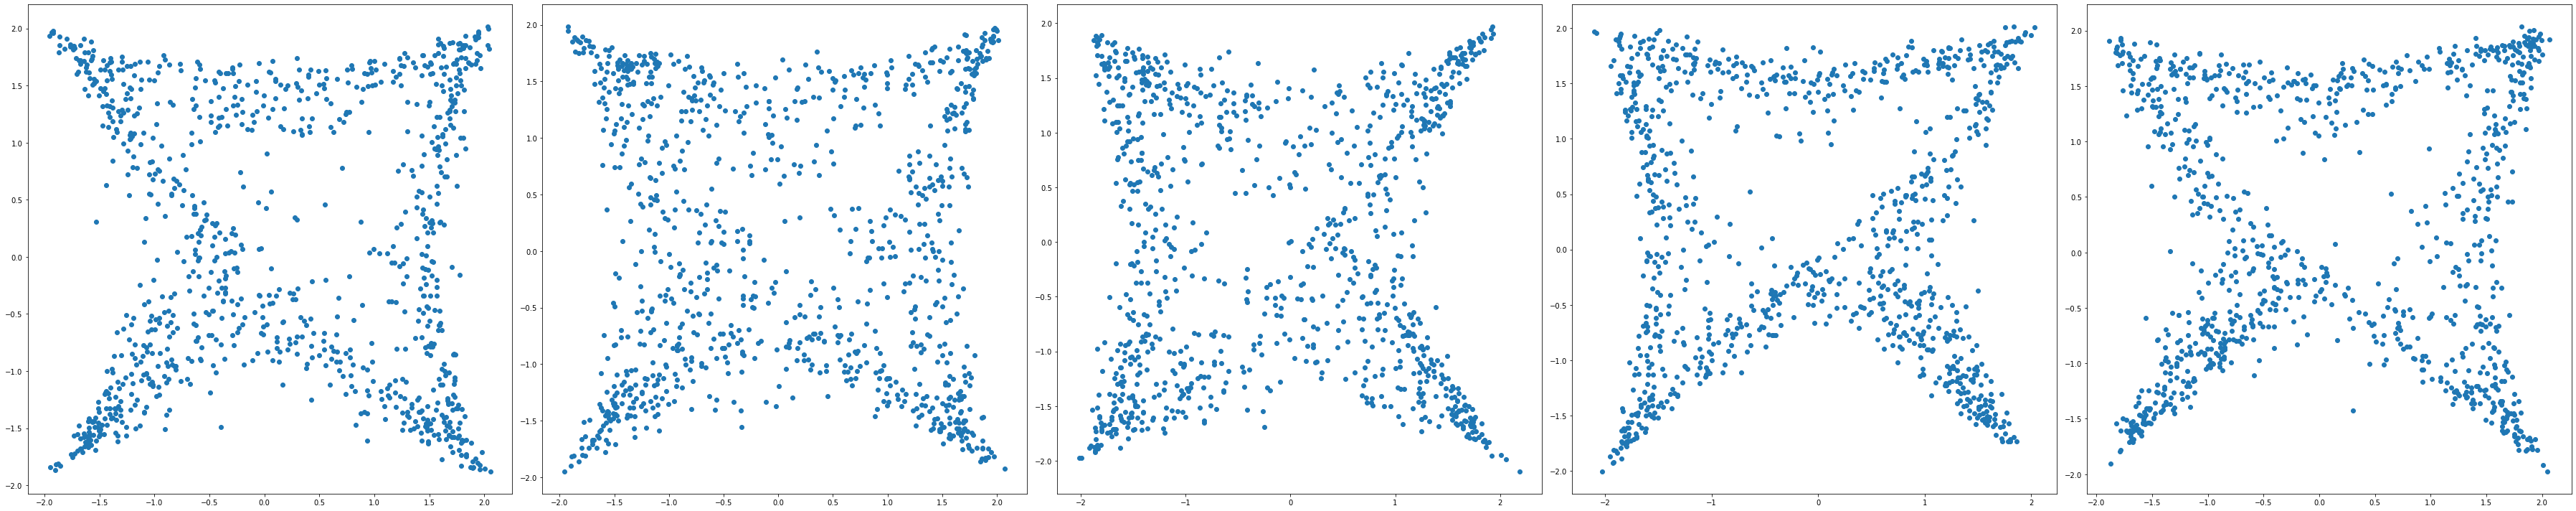

In [106]:
fig, axes = plt.subplots(1, 5, figsize=(50,10))
for i in range(5):
    star = sample_star(star_model, T, 1000)
    axes[i].scatter(star[:, 0], star[:, 1])

print('Some generated stars:')
plt.tight_layout()
plt.show()